## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


## ベイズ最適化

In [2]:
import os
import random
import pandas as pd
import numpy as np
import time
from matplotlib import pyplot as plt
from natsort import natsorted 
import time
import lightgbm as lgb
import optuna.integration.lightgbm as opt_lgb
from sklearn.model_selection import GroupKFold
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

### optuna.integration.lightgbm によるハイパーパラメーター調整実施

[I 2021-12-27 16:22:56,344] A new study created in memory with name: no-name-76656f16-d990-4c21-ab2a-03aa330cbc29
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  14%|######4                                      | 1/7 [00:00<00:02,  2.65it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.148039	Test's rmse: 0.34123
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  29%|############8                                | 2/7 [00:00<00:02,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119969	Test's rmse: 0.363198
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  43%|###################2                         | 3/7 [00:01<00:01,  2.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.112125	Test's rmse: 0.351581
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  57%|#########################7                   | 4/7 [00:01<00:01,  2.50it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153983	Test's rmse: 0.34335
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  71%|################################1            | 5/7 [00:02<00:00,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.107351	Test's rmse: 0.353489
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230:  86%|######################################5      | 6/7 [00:02<00:00,  2.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.105091	Test's rmse: 0.352722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003026 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.341230: 100%|#############################################| 7/7 [00:02<00:00,  2.39it/s]


Early stopping, best iteration is:
[46]	Train's rmse: 0.145024	Test's rmse: 0.345074


num_leaves, val_score: 0.341230:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000784 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:   5%|##5                                               | 1/20 [00:00<00:05,  3.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.124883	Test's rmse: 0.341498
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000846 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  10%|#####                                             | 2/20 [00:01<00:20,  1.12s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.140926	Test's rmse: 0.344277
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  15%|#######5                                          | 3/20 [00:04<00:26,  1.56s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121364	Test's rmse: 0.344126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  20%|##########                                        | 4/20 [00:04<00:20,  1.28s/it]

Early stopping, best iteration is:
[41]	Train's rmse: 0.143888	Test's rmse: 0.345127
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  25%|############5                                     | 5/20 [00:06<00:23,  1.55s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121364	Test's rmse: 0.344126
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000837 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341230:  30%|###############                                   | 6/20 [00:08<00:20,  1.45s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.141952	Test's rmse: 0.343256
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341082:  35%|#################5                                | 7/20 [00:09<00:15,  1.23s/it]

Early stopping, best iteration is:
[41]	Train's rmse: 0.143816	Test's rmse: 0.344991
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119614	Test's rmse: 0.341082


num_leaves, val_score: 0.341082:  40%|####################                              | 8/20 [00:09<00:10,  1.12it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001850 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341082:  45%|######################5                           | 9/20 [00:10<00:09,  1.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.119631	Test's rmse: 0.346649
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000871 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.341082:  50%|########################5                        | 10/20 [00:11<00:10,  1.07s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.123243	Test's rmse: 0.346558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001839 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336448:  55%|##########################9                      | 11/20 [00:11<00:07,  1.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12906	Test's rmse: 0.339525
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[39]	Train's rmse: 0.150586	Test's rmse: 0.336448


num_leaves, val_score: 0.336448:  60%|#############################4                   | 12/20 [00:11<00:04,  1.61it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.336448:  65%|###############################8                 | 13/20 [00:12<00:04,  1.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121705	Test's rmse: 0.344264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  75%|####################################7            | 15/20 [00:13<00:02,  2.26it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.141098	Test's rmse: 0.345866
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000725 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174981	Test's rmse: 0.328631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used fea

num_leaves, val_score: 0.328631:  80%|#######################################2         | 16/20 [00:14<00:03,  1.33it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.140175	Test's rmse: 0.347993
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000666 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.328631:  85%|#########################################6       | 17/20 [00:16<00:03,  1.16s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142618	Test's rmse: 0.347634
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  90%|############################################1    | 18/20 [00:17<00:02,  1.01s/it]

Early stopping, best iteration is:
[48]	Train's rmse: 0.142061	Test's rmse: 0.344261
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631:  95%|##############################################5  | 19/20 [00:18<00:00,  1.01it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.138024	Test's rmse: 0.344908
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.328631: 100%|#################################################| 20/20 [00:18<00:00,  1.06it/s]


Early stopping, best iteration is:
[36]	Train's rmse: 0.150315	Test's rmse: 0.346644


bagging, val_score: 0.328631:  10%|#####3                                               | 1/10 [00:00<00:01,  8.33it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000724 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170863	Test's rmse: 0.329144
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000941 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validat

bagging, val_score: 0.328631:  20%|##########6                                          | 2/10 [00:00<00:01,  7.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173068	Test's rmse: 0.332721
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001016 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.328631:  30%|###############9                                     | 3/10 [00:00<00:00,  7.36it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.181073	Test's rmse: 0.329377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.325775:  40%|#####################2                               | 4/10 [00:00<00:00,  6.91it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166035	Test's rmse: 0.325775
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000772 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.325775:  50%|##########################5                          | 5/10 [00:00<00:00,  6.96it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164586	Test's rmse: 0.326972
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001062 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.325775:  60%|###############################8                     | 6/10 [00:00<00:00,  7.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16953	Test's rmse: 0.331973
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000824 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349


bagging, val_score: 0.325775:  70%|#####################################                | 7/10 [00:00<00:00,  7.33it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[88]	Train's rmse: 0.174159	Test's rmse: 0.334652
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.325775:  80%|##########################################4          | 8/10 [00:01<00:00,  7.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173379	Test's rmse: 0.331505
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.325775:  90%|###############################################7     | 9/10 [00:01<00:00,  7.38it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171129	Test's rmse: 0.331597
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349


bagging, val_score: 0.325775: 100%|####################################################| 10/10 [00:01<00:00,  7.30it/s]


Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173255	Test's rmse: 0.333983


feature_fraction_stage2, val_score: 0.325775:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.325775:  17%|######3                               | 1/6 [00:00<00:00,  7.13it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161122	Test's rmse: 0.333675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.325641:  33%|############6                         | 2/6 [00:00<00:00,  7.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168591	Test's rmse: 0.325641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001222 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


feature_fraction_stage2, val_score: 0.325641:  50%|###################                   | 3/6 [00:00<00:00,  6.99it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16608	Test's rmse: 0.327984
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.325641:  67%|#########################3            | 4/6 [00:00<00:00,  7.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166259	Test's rmse: 0.325686
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.325641:  83%|###############################6      | 5/6 [00:00<00:00,  6.67it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166035	Test's rmse: 0.325775
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000822 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


feature_fraction_stage2, val_score: 0.325641: 100%|######################################| 6/6 [00:00<00:00,  6.83it/s]


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16608	Test's rmse: 0.327984


regularization_factors, val_score: 0.325641:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:   5%|#9                                    | 1/20 [00:00<00:02,  6.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170087	Test's rmse: 0.323648
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001234 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  10%|###8                                  | 2/20 [00:00<00:03,  4.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168591	Test's rmse: 0.325641
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.323648:  15%|#####7                                | 3/20 [00:00<00:03,  5.51it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168591	Test's rmse: 0.325641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005800 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168593	Test's rmse: 0.325643

regularization_factors, val_score: 0.323648:  25%|#########5                            | 5/20 [00:00<00:02,  5.16it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001646 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168863	Test's rmse: 0.326151
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000701 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  30%|###########4                          | 6/20 [00:01<00:02,  5.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168591	Test's rmse: 0.325641
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  35%|#############3                        | 7/20 [00:01<00:02,  6.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168024	Test's rmse: 0.324104
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000709 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.323648:  40%|###############2                      | 8/20 [00:01<00:01,  6.35it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168594	Test's rmse: 0.325642
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000818 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  45%|#################1                    | 9/20 [00:01<00:01,  6.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16923	Test's rmse: 0.326407
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000752 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  50%|##################5                  | 10/20 [00:01<00:01,  6.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168591	Test's rmse: 0.325641
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.323648:  55%|####################3                | 11/20 [00:01<00:01,  6.54it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173633	Test's rmse: 0.334396
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000748 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  60%|######################2              | 12/20 [00:01<00:01,  6.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169825	Test's rmse: 0.327688
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  65%|########################             | 13/20 [00:02<00:01,  6.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16853	Test's rmse: 0.326399


regularization_factors, val_score: 0.323648:  70%|#########################9           | 14/20 [00:02<00:00,  6.59it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.167044	Test's rmse: 0.324671
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  75%|###########################7         | 15/20 [00:02<00:00,  6.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170732	Test's rmse: 0.330438
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  80%|#############################6       | 16/20 [00:02<00:00,  6.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.17074	Test's rmse: 0.327702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001788 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.323648:  85%|###############################4     | 17/20 [00:02<00:00,  6.48it/s]

[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169732	Test's rmse: 0.328014
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001741 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  90%|#################################3   | 18/20 [00:02<00:00,  6.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168024	Test's rmse: 0.324103
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.323648:  95%|###################################1 | 19/20 [00:03<00:00,  6.51it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171386	Test's rmse: 0.324481
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001749 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.323648: 100%|#####################################| 20/20 [00:03<00:00,  6.21it/s]


[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168592	Test's rmse: 0.325641


min_data_in_leaf, val_score: 0.323648:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.322892:  20%|#########                                    | 1/5 [00:00<00:00,  6.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161543	Test's rmse: 0.322892
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002482 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.322050:  40%|##################                           | 2/5 [00:00<00:00,  7.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.161873	Test's rmse: 0.32205
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000710 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349


min_data_in_leaf, val_score: 0.322050:  60%|###########################                  | 3/5 [00:00<00:00,  7.00it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.173591	Test's rmse: 0.326828
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000782 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.322050:  80%|####################################         | 4/5 [00:00<00:00,  7.10it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.231252	Test's rmse: 0.377475
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001885 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2296
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 22
[LightGBM] [Info] Start training from score 0.356349
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.322050: 100%|#############################################| 5/5 [00:00<00:00,  7.00it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.268176	Test's rmse: 0.413186


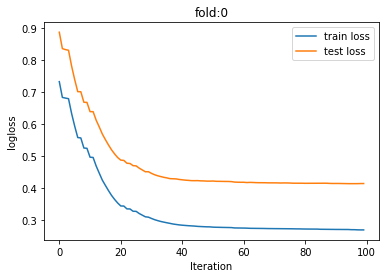

[I 2021-12-27 16:23:24,670] A new study created in memory with name: no-name-3189641f-3fad-4b2e-bbbc-e23050da3c44
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  14%|######4                                      | 1/7 [00:00<00:02,  2.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133798	Test's rmse: 0.103132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  29%|############8                                | 2/7 [00:00<00:01,  2.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.131693	Test's rmse: 0.122502
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  43%|###################2                         | 3/7 [00:01<00:01,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148628	Test's rmse: 0.111997
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  57%|#########################7                   | 4/7 [00:01<00:01,  2.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144067	Test's rmse: 0.105227
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000751 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  71%|################################1            | 5/7 [00:02<00:00,  2.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136538	Test's rmse: 0.131841
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132:  86%|######################################5      | 6/7 [00:02<00:00,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134845	Test's rmse: 0.108049
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002047 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.103132: 100%|#############################################| 7/7 [00:03<00:00,  2.07it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.130288	Test's rmse: 0.11942


num_leaves, val_score: 0.103132:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:   5%|##5                                               | 1/20 [00:02<00:51,  2.73s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136547	Test's rmse: 0.115794
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  10%|#####                                             | 2/20 [00:04<00:43,  2.44s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134874	Test's rmse: 0.114709
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  15%|#######5                                          | 3/20 [00:06<00:37,  2.23s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136952	Test's rmse: 0.116941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  20%|##########                                        | 4/20 [00:07<00:26,  1.66s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1371	Test's rmse: 0.108819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  25%|############5                                     | 5/20 [00:09<00:27,  1.85s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139352	Test's rmse: 0.11909
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.103132:  30%|###############                                   | 6/20 [00:10<00:21,  1.50s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137183	Test's rmse: 0.1082
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002269 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.102863:  35%|#################5                                | 7/20 [00:11<00:14,  1.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140106	Test's rmse: 0.102863
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000679 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.102863:  40%|####################                              | 8/20 [00:12<00:16,  1.36s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138487	Test's rmse: 0.116371
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.102863:  45%|######################5                           | 9/20 [00:13<00:12,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138705	Test's rmse: 0.108003
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000912 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.102863:  50%|########################5                        | 10/20 [00:14<00:10,  1.06s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137381	Test's rmse: 0.108182
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141582	Test's rmse: 0.113459


num_leaves, val_score: 0.102863:  55%|##########################9                      | 11/20 [00:14<00:07,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.102863:  60%|#############################4                   | 12/20 [00:14<00:05,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134069	Test's rmse: 0.103302
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000874 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  65%|###############################8                 | 13/20 [00:15<00:03,  1.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  70%|##################################3              | 14/20 [00:16<00:04,  1.37it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136943	Test's rmse: 0.109271
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001697 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  75%|####################################7            | 15/20 [00:16<00:03,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137487	Test's rmse: 0.103386
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  80%|#######################################2         | 16/20 [00:17<00:03,  1.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138683	Test's rmse: 0.113166
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002371 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  85%|#########################################6       | 17/20 [00:18<00:02,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137178	Test's rmse: 0.106667
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000629 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  90%|############################################1    | 18/20 [00:19<00:01,  1.26it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138224	Test's rmse: 0.113722
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004164 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946:  95%|##############################################5  | 19/20 [00:19<00:00,  1.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134559	Test's rmse: 0.107707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.100946: 100%|#################################################| 20/20 [00:20<00:00,  1.02s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136469	Test's rmse: 0.113242


bagging, val_score: 0.100946:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.100946:  10%|#####3                                               | 1/10 [00:00<00:01,  5.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171628	Test's rmse: 0.110473
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.100946:  20%|##########6                                          | 2/10 [00:00<00:01,  5.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152464	Test's rmse: 0.112597
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001474 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171961	Test's rmse: 0.111467


bagging, val_score: 0.100946:  30%|###############9                                     | 3/10 [00:00<00:01,  5.13it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.100946:  40%|#####################2                               | 4/10 [00:00<00:01,  5.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186488	Test's rmse: 0.117316
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.168251	Test's rmse: 0.110921


bagging, val_score: 0.100946:  50%|##########################5                          | 5/10 [00:00<00:00,  5.02it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000544 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.100946:  60%|###############################8                     | 6/10 [00:01<00:00,  5.14it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.190898	Test's rmse: 0.130649
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002076 seconds.
You can set `force_col_wise=true` to remove the overhead.


bagging, val_score: 0.100946:  70%|#####################################                | 7/10 [00:01<00:00,  5.11it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.171087	Test's rmse: 0.110553


bagging, val_score: 0.100946:  80%|##########################################4          | 8/10 [00:01<00:00,  4.96it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.190719	Test's rmse: 0.119838


[I 2021-12-27 16:23:50,069] Trial 34 finished with value: 0.1198376849758618 and parameters: {'bagging_fraction': 0.5027190615131754, 'bagging_freq': 3}. Best is trial 27 with value: 0.11047335956156691.
bagging, val_score: 0.100946:  80%|##########################################4          | 8/10 [00:01<00:00,  4.96it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.182371	Test's rmse: 0.118025


bagging, val_score: 0.100946:  90%|###############################################7     | 9/10 [00:02<00:00,  4.81it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001793 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.177058	Test's rmse: 0.110304


feature_fraction_stage2, val_score: 0.100946:  17%|######3                               | 1/6 [00:00<00:00,  6.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000530 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128966	Test's rmse: 0.107188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001485 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22


feature_fraction_stage2, val_score: 0.100946:  33%|############6                         | 2/6 [00:00<00:00,  6.14it/s]

[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135872	Test's rmse: 0.103238
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.100946:  50%|###################                   | 3/6 [00:00<00:00,  6.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141445	Test's rmse: 0.102061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946


feature_fraction_stage2, val_score: 0.100946:  83%|###############################6      | 5/6 [00:00<00:00,  6.17it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141445	Test's rmse: 0.102061
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.100946: 100%|######################################| 6/6 [00:01<00:00,  5.81it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135872	Test's rmse: 0.103238


regularization_factors, val_score: 0.100946:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000548 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946


regularization_factors, val_score: 0.100946:   5%|#9                                    | 1/20 [00:00<00:03,  4.84it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000604 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.100946:  10%|###8                                  | 2/20 [00:00<00:03,  5.20it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136894	Test's rmse: 0.103288
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290


regularization_factors, val_score: 0.100946:  15%|#####7                                | 3/20 [00:00<00:03,  5.07it/s]

[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136279	Test's rmse: 0.103645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.100946:  20%|#######6                              | 4/20 [00:00<00:02,  5.47it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001796 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


regularization_factors, val_score: 0.100946:  25%|#########5                            | 5/20 [00:00<00:02,  5.64it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.100946:  30%|###########4                          | 6/20 [00:01<00:02,  5.86it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.135433	Test's rmse: 0.106325
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001431 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137712	Test's rmse: 0.110598


regularization_factors, val_score: 0.100946:  40%|###############2                      | 8/20 [00:01<00:01,  6.10it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14884	Test's rmse: 0.108636
[LightGBM] [Warning] Auto-choosing col-wise mu

regularization_factors, val_score: 0.100946:  50%|##################5                  | 10/20 [00:01<00:01,  6.21it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1334	Test's rmse: 0.105575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139774	Test's rmse: 0.104322


regularization_factors, val_score: 0.100946:  55%|####################3                | 11/20 [00:01<00:01,  5.94it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001396 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141849	Test's rmse: 0.101383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001320 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.100946:  60%|######################2              | 12/20 [00:02<00:01,  5.99it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001594 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.100946:  65%|########################             | 13/20 [00:02<00:01,  5.75it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000637 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808


regularization_factors, val_score: 0.100946:  70%|#########################9           | 14/20 [00:02<00:01,  5.80it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.100946:  75%|###########################7         | 15/20 [00:02<00:00,  5.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000486 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946


regularization_factors, val_score: 0.100946:  85%|###############################4     | 17/20 [00:03<00:00,  5.28it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001463 seconds.
You can set `force_col_wise=true` to remove the overhead.


regularization_factors, val_score: 0.100946:  90%|#################################3   | 18/20 [00:03<00:00,  5.20it/s]

[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.100946:  95%|###################################1 | 19/20 [00:03<00:00,  4.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137363	Test's rmse: 0.100946
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.100946: 100%|#####################################| 20/20 [00:03<00:00,  5.27it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138664	Test's rmse: 0.102779


min_data_in_leaf, val_score: 0.100946:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094999:  20%|#########                                    | 1/5 [00:00<00:00,  4.41it/s]

Early stopping, best iteration is:
[39]	Train's rmse: 0.137959	Test's rmse: 0.0949986


[I 2021-12-27 16:23:55,585] Trial 63 finished with value: 0.09499862562825427 and parameters: {'min_child_samples': 10}. Best is trial 63 with value: 0.09499862562825427.
min_data_in_leaf, val_score: 0.094999:  20%|#########                                    | 1/5 [00:00<00:00,  4.41it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002306 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.243029	Test's rmse: 0.182831


min_data_in_leaf, val_score: 0.094999:  40%|##################                           | 2/5 [00:00<00:00,  4.26it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.094999:  60%|###########################                  | 3/5 [00:00<00:00,  4.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0332599	Test's rmse: 0.121042


[I 2021-12-27 16:23:56,034] Trial 65 finished with value: 0.12104246896280234 and parameters: {'min_child_samples': 5}. Best is trial 63 with value: 0.09499862562825427.
min_data_in_leaf, val_score: 0.094999:  60%|###########################                  | 3/5 [00:00<00:00,  4.49it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160988	Test's rmse: 0.112532


min_data_in_leaf, val_score: 0.094999:  80%|####################################         | 4/5 [00:00<00:00,  4.78it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001763 seconds.
You can set `force_col_wise=true` to remove the overhead.


min_data_in_leaf, val_score: 0.094999: 100%|#############################################| 5/5 [00:01<00:00,  4.84it/s]


[LightGBM] [Info] Total Bins 2290
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 22
[LightGBM] [Info] Start training from score 0.345808
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[29]	Train's rmse: 0.32908	Test's rmse: 0.229543


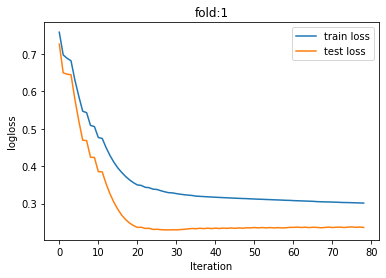

[I 2021-12-27 16:23:56,585] A new study created in memory with name: no-name-c3e9970c-0b0c-43ae-bcb2-ce18ce8b7a0c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.169026:  14%|######4                                      | 1/7 [00:00<00:01,  3.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.134967	Test's rmse: 0.169026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.149363:  29%|############8                                | 2/7 [00:00<00:01,  3.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.12905	Test's rmse: 0.149363
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002924 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  43%|###################2                         | 3/7 [00:00<00:01,  3.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14443	Test's rmse: 0.139906
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000458 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  57%|#########################7                   | 4/7 [00:01<00:00,  3.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.155903	Test's rmse: 0.140315
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001520 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  71%|################################1            | 5/7 [00:01<00:00,  3.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129464	Test's rmse: 0.160576
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906:  86%|######################################5      | 6/7 [00:01<00:00,  3.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146988	Test's rmse: 0.141503
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000795 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.139906: 100%|#############################################| 7/7 [00:01<00:00,  3.62it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.128939	Test's rmse: 0.159312


num_leaves, val_score: 0.139906:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:   5%|##5                                               | 1/20 [00:01<00:24,  1.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144088	Test's rmse: 0.142462
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  10%|#####                                             | 2/20 [00:02<00:21,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142954	Test's rmse: 0.145943
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002124 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  15%|#######5                                          | 3/20 [00:03<00:19,  1.15s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141258	Test's rmse: 0.144449
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  20%|##########                                        | 4/20 [00:04<00:17,  1.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.143453	Test's rmse: 0.146126
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  25%|############5                                     | 5/20 [00:05<00:15,  1.02s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140969	Test's rmse: 0.141067
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  30%|###############                                   | 6/20 [00:06<00:14,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145182	Test's rmse: 0.145528
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  35%|#################5                                | 7/20 [00:07<00:11,  1.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145256	Test's rmse: 0.141554
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002336 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.139906:  40%|####################                              | 8/20 [00:08<00:13,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141258	Test's rmse: 0.144449
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  45%|######################5                           | 9/20 [00:08<00:09,  1.16it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14426	Test's rmse: 0.138532
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002492 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  50%|########################5                        | 10/20 [00:09<00:08,  1.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144556	Test's rmse: 0.143073
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  55%|##########################9                      | 11/20 [00:10<00:06,  1.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142821	Test's rmse: 0.14169
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  60%|#############################4                   | 12/20 [00:11<00:06,  1.17it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144185	Test's rmse: 0.14383
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005123 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  65%|###############################8                 | 13/20 [00:12<00:06,  1.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.148441	Test's rmse: 0.141291
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  70%|##################################3              | 14/20 [00:12<00:04,  1.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137673	Test's rmse: 0.141727
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000581 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138532:  75%|####################################7            | 15/20 [00:13<00:03,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142887	Test's rmse: 0.140507
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002477 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138406:  80%|#######################################2         | 16/20 [00:14<00:03,  1.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138406:  85%|#########################################6       | 17/20 [00:15<00:02,  1.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145422	Test's rmse: 0.140813
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002061 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138406:  90%|############################################1    | 18/20 [00:15<00:01,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139114	Test's rmse: 0.142534
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138406:  95%|##############################################5  | 19/20 [00:15<00:00,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.142298	Test's rmse: 0.13921
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001220 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.138406: 100%|#################################################| 20/20 [00:16<00:00,  1.23it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14364	Test's rmse: 0.142128


bagging, val_score: 0.138406:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002288 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  10%|#####3                                               | 1/10 [00:00<00:03,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144376	Test's rmse: 0.146882
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000482 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  20%|##########6                                          | 2/10 [00:00<00:03,  2.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.176687	Test's rmse: 0.163832
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  30%|###############9                                     | 3/10 [00:01<00:02,  2.41it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169977	Test's rmse: 0.146248
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  40%|#####################2                               | 4/10 [00:01<00:02,  2.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.164086	Test's rmse: 0.152708
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000450 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  50%|##########################5                          | 5/10 [00:01<00:01,  2.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.16087	Test's rmse: 0.149993
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  60%|###############################8                     | 6/10 [00:02<00:01,  2.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174683	Test's rmse: 0.156669
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  70%|#####################################                | 7/10 [00:02<00:01,  2.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.170816	Test's rmse: 0.152094
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  80%|##########################################4          | 8/10 [00:03<00:00,  2.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.160655	Test's rmse: 0.148567
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000441 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406:  90%|###############################################7     | 9/10 [00:03<00:00,  2.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14456	Test's rmse: 0.145232
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000711 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.138406: 100%|####################################################| 10/10 [00:03<00:00,  2.66it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166407	Test's rmse: 0.156865


feature_fraction_stage2, val_score: 0.138406:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406:  17%|######3                               | 1/6 [00:00<00:01,  3.34it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406:  33%|############6                         | 2/6 [00:00<00:01,  3.18it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.138785	Test's rmse: 0.14824
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406:  50%|###################                   | 3/6 [00:00<00:00,  3.05it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146847	Test's rmse: 0.139753
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000529 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406:  67%|#########################3            | 4/6 [00:01<00:00,  2.93it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.146847	Test's rmse: 0.139753
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406:  83%|###############################6      | 5/6 [00:01<00:00,  3.00it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137118	Test's rmse: 0.142085
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.138406: 100%|######################################| 6/6 [00:01<00:00,  3.03it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137118	Test's rmse: 0.142085


regularization_factors, val_score: 0.138406:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001345 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:   5%|#9                                    | 1/20 [00:00<00:06,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144762	Test's rmse: 0.139512
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000566 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  10%|###8                                  | 2/20 [00:00<00:06,  2.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147654	Test's rmse: 0.138407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001648 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  15%|#####7                                | 3/20 [00:01<00:06,  2.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145428	Test's rmse: 0.14111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002536 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

regularization_factors, val_score: 0.138406:  20%|#######6                              | 4/20 [00:01<00:06,  2.49it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.137141	Test's rmse: 0.148256
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001422 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  25%|#########5                            | 5/20 [00:01<00:05,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145657	Test's rmse: 0.139508
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000650 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  30%|###########4                          | 6/20 [00:02<00:05,  2.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147654	Test's rmse: 0.138407
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  35%|#############3                        | 7/20 [00:02<00:05,  2.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14428	Test's rmse: 0.142652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  40%|###############2                      | 8/20 [00:03<00:04,  2.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.145427	Test's rmse: 0.14111
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  45%|#################1                    | 9/20 [00:03<00:04,  2.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.139759	Test's rmse: 0.142523
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  50%|##################5                  | 10/20 [00:03<00:03,  2.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.1464	Test's rmse: 0.140045
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001366 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  55%|####################3                | 11/20 [00:04<00:03,  2.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  60%|######################2              | 12/20 [00:04<00:03,  2.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138409
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  65%|########################             | 13/20 [00:05<00:02,  2.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  70%|#########################9           | 14/20 [00:05<00:02,  2.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000549 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  75%|###########################7         | 15/20 [00:05<00:01,  2.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  80%|#############################6       | 16/20 [00:06<00:01,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  85%|###############################4     | 17/20 [00:06<00:01,  2.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.140141	Test's rmse: 0.139785
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.138406:  90%|#################################3   | 18/20 [00:07<00:00,  2.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.151487	Test's rmse: 0.147616
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000445 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406:  95%|###################################1 | 19/20 [00:07<00:00,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138406
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.138406: 100%|#####################################| 20/20 [00:07<00:00,  2.52it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147652	Test's rmse: 0.138409


min_data_in_leaf, val_score: 0.138406:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.138406:  20%|#########                                    | 1/5 [00:00<00:01,  2.31it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.0521869	Test's rmse: 0.159101
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.138406:  40%|##################                           | 2/5 [00:00<00:01,  2.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.0602943	Test's rmse: 0.151349
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001551 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.138406:  60%|###########################                  | 3/5 [00:01<00:00,  2.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.285017	Test's rmse: 0.193801
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.138406:  80%|####################################         | 4/5 [00:01<00:00,  2.06it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.156316	Test's rmse: 0.154413
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 22
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.138406: 100%|#############################################| 5/5 [00:02<00:00,  2.07it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.230885	Test's rmse: 0.173137


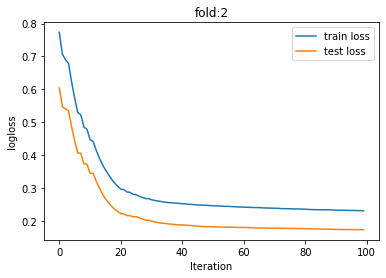

[I 2021-12-27 16:24:31,156] A new study created in memory with name: no-name-c19af797-ae60-446b-9f03-8657dcf8ba14
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001612 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.093056:  14%|######4                                      | 1/7 [00:00<00:01,  3.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.136853	Test's rmse: 0.0930559
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.090146:  29%|############8                                | 2/7 [00:00<00:01,  2.75it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.126647	Test's rmse: 0.0901461
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001999 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.083066:  43%|###################2                         | 3/7 [00:01<00:01,  2.82it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.133355	Test's rmse: 0.0830657
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000642 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  57%|#########################7                   | 4/7 [00:01<00:01,  2.81it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165773	Test's rmse: 0.0217725
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  71%|################################1            | 5/7 [00:01<00:00,  2.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.144156	Test's rmse: 0.0541509
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773:  86%|######################################5      | 6/7 [00:02<00:00,  2.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.150344	Test's rmse: 0.0401701
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001682 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.021773: 100%|#############################################| 7/7 [00:02<00:00,  2.96it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.129613	Test's rmse: 0.0803229


num_leaves, val_score: 0.021773:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.021773:   5%|##5                                               | 1/20 [00:01<00:27,  1.47s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221605
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002638 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021773:  10%|#####                                             | 2/20 [00:02<00:23,  1.28s/it]

Early stopping, best iteration is:
[47]	Train's rmse: 0.164184	Test's rmse: 0.0220575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149615	Test's rmse: 0.027645


num_leaves, val_score: 0.021773:  15%|#######5                                          | 3/20 [00:02<00:13,  1.27it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000655 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021773:  20%|##########                                        | 4/20 [00:03<00:13,  1.17it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166137	Test's rmse: 0.022152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021773:  25%|############5                                     | 5/20 [00:04<00:14,  1.02it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165305	Test's rmse: 0.0221492
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002814 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021773:  30%|###############                                   | 6/20 [00:05<00:12,  1.08it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165305	Test's rmse: 0.0220652
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021773:  35%|#################5                                | 7/20 [00:06<00:10,  1.24it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166142	Test's rmse: 0.0221827
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000638 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021652:  40%|####################                              | 8/20 [00:06<00:07,  1.56it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165436	Test's rmse: 0.0216517
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000648 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


num_leaves, val_score: 0.021652:  45%|######################5                           | 9/20 [00:07<00:09,  1.17it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165303	Test's rmse: 0.0221594
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021500:  50%|########################5                        | 10/20 [00:08<00:06,  1.44it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165638	Test's rmse: 0.0214998
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.021500:  55%|##########################9                      | 11/20 [00:09<00:06,  1.49it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.167384	Test's rmse: 0.022408
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.158164	Test's rmse: 0.025708


num_leaves, val_score: 0.021500:  60%|#############################4                   | 12/20 [00:09<00:04,  1.94it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000630 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  65%|###############################8                 | 13/20 [00:12<00:10,  1.47s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001533 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  70%|##################################3              | 14/20 [00:13<00:07,  1.31s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.147995	Test's rmse: 0.0297604
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  75%|####################################7            | 15/20 [00:14<00:05,  1.11s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.167423	Test's rmse: 0.0219488
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  80%|#######################################2         | 16/20 [00:15<00:04,  1.12s/it]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166215	Test's rmse: 0.0219337
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002157 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  85%|#########################################6       | 17/20 [00:16<00:02,  1.02it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166048	Test's rmse: 0.0211276
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001003 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  90%|############################################1    | 18/20 [00:17<00:01,  1.04it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166251	Test's rmse: 0.0219097
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671:  95%|##############################################5  | 19/20 [00:17<00:00,  1.16it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165788	Test's rmse: 0.0216049
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.020671: 100%|#################################################| 20/20 [00:18<00:00,  1.08it/s]


Early stopping, best iteration is:
[42]	Train's rmse: 0.167442	Test's rmse: 0.0218946


bagging, val_score: 0.020671:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003515 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  10%|#####3                                               | 1/10 [00:00<00:06,  1.38it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.18831	Test's rmse: 0.0281323
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000968 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  20%|##########6                                          | 2/10 [00:01<00:06,  1.24it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.191658	Test's rmse: 0.0359369
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001070 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  30%|###############9                                     | 3/10 [00:02<00:05,  1.33it/s]

Did not meet early stopping. Best iteration is:
[98]	Train's rmse: 0.191456	Test's rmse: 0.0400076
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  40%|#####################2                               | 4/10 [00:02<00:03,  1.54it/s]

Did not meet early stopping. Best iteration is:
[93]	Train's rmse: 0.181028	Test's rmse: 0.035271
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  50%|##########################5                          | 5/10 [00:03<00:02,  1.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.159671	Test's rmse: 0.0255163
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000594 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  60%|###############################8                     | 6/10 [00:03<00:02,  1.84it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.190657	Test's rmse: 0.0411187
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  70%|#####################################                | 7/10 [00:04<00:01,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.166308	Test's rmse: 0.0272253
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001300 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  80%|##########################################4          | 8/10 [00:04<00:01,  1.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.174774	Test's rmse: 0.0324424
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671:  90%|###############################################7     | 9/10 [00:05<00:00,  1.79it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.186009	Test's rmse: 0.029476
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.020671: 100%|####################################################| 10/10 [00:05<00:00,  1.67it/s]


Early stopping, best iteration is:
[44]	Train's rmse: 0.196955	Test's rmse: 0.031762


feature_fraction_stage2, val_score: 0.020671:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000747 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.020671:  33%|############6                         | 1/3 [00:00<00:00,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.152575	Test's rmse: 0.0473096
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.020671:  67%|#########################3            | 2/3 [00:00<00:00,  2.30it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.16676	Test's rmse: 0.0206715
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.020671: 100%|######################################| 3/3 [00:01<00:00,  1.78it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.149851	Test's rmse: 0.0474161


regularization_factors, val_score: 0.020671:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:   5%|#9                                    | 1/20 [00:01<00:23,  1.24s/it]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166592	Test's rmse: 0.0215945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000586 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:  10%|###8                                  | 2/20 [00:02<00:24,  1.35s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.165824	Test's rmse: 0.0213803
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000626 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:  15%|#####7                                | 3/20 [00:03<00:22,  1.34s/it]

Early stopping, best iteration is:
[45]	Train's rmse: 0.16587	Test's rmse: 0.021105
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000659 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:  20%|#######6                              | 4/20 [00:05<00:21,  1.32s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.14794	Test's rmse: 0.0296758
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000731 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

regularization_factors, val_score: 0.020671:  25%|#########5                            | 5/20 [00:06<00:17,  1.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.154875	Test's rmse: 0.028337
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001017 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.020671:  30%|###########4                          | 6/20 [00:07<00:15,  1.12s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.166525	Test's rmse: 0.0213283
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020671:  35%|#############3                        | 7/20 [00:08<00:13,  1.06s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.169758	Test's rmse: 0.0219074
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:  40%|###############2                      | 8/20 [00:09<00:12,  1.05s/it]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166759	Test's rmse: 0.0206723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.020671:  45%|#################1                    | 9/20 [00:10<00:11,  1.03s/it]

Early stopping, best iteration is:
[43]	Train's rmse: 0.165777	Test's rmse: 0.0215222
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000749 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.020671:  50%|##################5                  | 10/20 [00:10<00:08,  1.18it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.020281:  55%|####################3                | 11/20 [00:11<00:06,  1.29it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.019128:  60%|######################2              | 12/20 [00:11<00:05,  1.40it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.019128:  65%|########################             | 13/20 [00:12<00:04,  1.53it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.141427	Test's rmse: 0.0260936
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

regularization_factors, val_score: 0.019128:  70%|#########################9           | 14/20 [00:13<00:04,  1.30it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.166694	Test's rmse: 0.0210526
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000683 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.019128:  75%|###########################7         | 15/20 [00:14<00:04,  1.19it/s]

Early stopping, best iteration is:
[47]	Train's rmse: 0.163639	Test's rmse: 0.0216264
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.019128:  80%|#############################6       | 16/20 [00:15<00:03,  1.15it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.170168	Test's rmse: 0.0207757
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019128:  85%|###############################4     | 17/20 [00:16<00:02,  1.11it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.166043	Test's rmse: 0.0206048
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000970 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

regularization_factors, val_score: 0.019128:  90%|#################################3   | 18/20 [00:17<00:01,  1.15it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.019128:  95%|###################################1 | 19/20 [00:17<00:00,  1.20it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[42]	Train's rmse: 0.166421	Test's rmse: 0.0206224
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000959 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.019128: 100%|#####################################| 20/20 [00:18<00:00,  1.06it/s]


Early stopping, best iteration is:
[45]	Train's rmse: 0.166985	Test's rmse: 0.0207443


min_data_in_leaf, val_score: 0.019128:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Ligh

min_data_in_leaf, val_score: 0.019128:  20%|#########                                    | 1/5 [00:00<00:02,  1.83it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.121377	Test's rmse: 0.0258128
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000694 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

min_data_in_leaf, val_score: 0.019128:  40%|##################                           | 2/5 [00:01<00:01,  1.97it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[39]	Train's rmse: 0.256819	Test's rmse: 0.0561878
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000780 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 22
[LightGBM] [Info] Start training 

min_data_in_leaf, val_score: 0.019128:  60%|###########################                  | 3/5 [00:01<00:00,  2.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.019128:  80%|####################################         | 4/5 [00:02<00:00,  1.95it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.019128: 100%|#############################################| 5/5 [00:02<00:00,  1.97it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[44]	Train's rmse: 0.176214	Test's rmse: 0.0273197


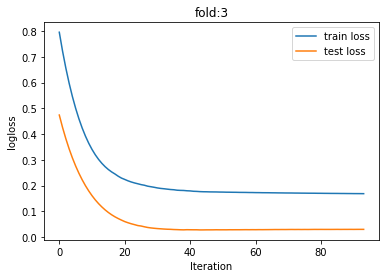

[I 2021-12-27 16:25:21,237] A new study created in memory with name: no-name-aaad2dcf-1518-4fc2-b038-0fe2ce97e0b3
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002549 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.391274:  14%|######4                                      | 1/7 [00:00<00:03,  1.98it/s]

Early stopping, best iteration is:
[42]	Train's rmse: 0.154665	Test's rmse: 0.391274
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  29%|############8                                | 2/7 [00:01<00:03,  1.63it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15906	Test's rmse: 0.373033
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000950 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  43%|###################2                         | 3/7 [00:01<00:02,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121956	Test's rmse: 0.418672
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000833 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  57%|#########################7                   | 4/7 [00:02<00:01,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.121667	Test's rmse: 0.411929
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001891 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  71%|################################1            | 5/7 [00:03<00:01,  1.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.122753	Test's rmse: 0.417714
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000908 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033:  86%|######################################5      | 6/7 [00:03<00:00,  1.68it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.15737	Test's rmse: 0.378682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001706 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.373033: 100%|#############################################| 7/7 [00:04<00:00,  1.64it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.120118	Test's rmse: 0.417415


num_leaves, val_score: 0.373033:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:   5%|##5                                               | 1/20 [00:00<00:14,  1.32it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159228	Test's rmse: 0.376112
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000790 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  10%|#####                                             | 2/20 [00:02<00:23,  1.33s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153026	Test's rmse: 0.375781
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  15%|#######5                                          | 3/20 [00:03<00:22,  1.33s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153032	Test's rmse: 0.375769
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  20%|##########                                        | 4/20 [00:04<00:15,  1.01it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.155954	Test's rmse: 0.374525
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  25%|############5                                     | 5/20 [00:05<00:17,  1.18s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153033	Test's rmse: 0.375774
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  30%|###############                                   | 6/20 [00:07<00:20,  1.44s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159186	Test's rmse: 0.376065
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001224 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  35%|#################5                                | 7/20 [00:09<00:18,  1.41s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159189	Test's rmse: 0.376066
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  40%|####################                              | 8/20 [00:11<00:20,  1.68s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159181	Test's rmse: 0.376085
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.373033:  45%|######################5                           | 9/20 [00:14<00:22,  2.02s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.371918:  50%|########################5                        | 10/20 [00:14<00:15,  1.57s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159223	Test's rmse: 0.371918
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.371918:  55%|##########################9                      | 11/20 [00:15<00:11,  1.23s/it]

Early stopping, best iteration is:
[31]	Train's rmse: 0.160116	Test's rmse: 0.374828
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000753 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.358268:  60%|#############################4                   | 12/20 [00:15<00:07,  1.07it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.158953	Test's rmse: 0.358268
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000951 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.343336:  65%|###############################8                 | 13/20 [00:15<00:05,  1.37it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.155086	Test's rmse: 0.354284
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000742 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.169751	Test's rmse: 0.343336


num_leaves, val_score: 0.343336:  70%|##################################3              | 14/20 [00:15<00:03,  1.77it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001339 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.343336:  75%|####################################7            | 15/20 [00:18<00:06,  1.27s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.15918	Test's rmse: 0.376064
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.343336:  80%|#######################################2         | 16/20 [00:19<00:04,  1.24s/it]

Early stopping, best iteration is:
[32]	Train's rmse: 0.159231	Test's rmse: 0.37611
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000839 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.343336:  85%|#########################################6       | 17/20 [00:20<00:03,  1.15s/it]

Early stopping, best iteration is:
[33]	Train's rmse: 0.15732	Test's rmse: 0.373227
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000933 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196657	Test's rmse: 0.33783


num_leaves, val_score: 0.337830:  90%|############################################1    | 18/20 [00:21<00:01,  1.16it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000848 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337830:  95%|##############################################5  | 19/20 [00:25<00:01,  1.86s/it]

Early stopping, best iteration is:
[39]	Train's rmse: 0.153025	Test's rmse: 0.37578
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003016 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.337830: 100%|#################################################| 20/20 [00:26<00:00,  1.35s/it]


Early stopping, best iteration is:
[39]	Train's rmse: 0.153043	Test's rmse: 0.375766


bagging, val_score: 0.337830:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198551	Test's rmse: 0.326831


bagging, val_score: 0.326831:  20%|##########6                                          | 2/10 [00:00<00:01,  4.87it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001435 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.196389	Test's rmse: 0.330597
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.326831:  30%|###############9                                     | 3/10 [00:00<00:01,  5.10it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196512	Test's rmse: 0.332862
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000853 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.326831:  30%|###############9                                     | 3/10 [00:00<00:01,  5.10it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[92]	Train's rmse: 0.196552	Test's rmse: 0.333291


bagging, val_score: 0.326831:  40%|#####################2                               | 4/10 [00:01<00:01,  4.83it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000903 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.200921	Test's rmse: 0.339811


bagging, val_score: 0.326831:  60%|###############################8                     | 6/10 [00:01<00:00,  4.80it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001359 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[97]	Train's rmse: 0.198392	Test's rmse: 0.339193
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001138 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


bagging, val_score: 0.326831:  70%|#####################################                | 7/10 [00:01<00:00,  5.02it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.197779	Test's rmse: 0.329761
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000998 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462


bagging, val_score: 0.326831:  80%|##########################################4          | 8/10 [00:01<00:00,  5.16it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196876	Test's rmse: 0.330945
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.326831:  90%|###############################################7     | 9/10 [00:01<00:00,  5.43it/s]

Did not meet early stopping. Best iteration is:
[99]	Train's rmse: 0.196377	Test's rmse: 0.334258
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[96]	Train's rmse: 0.197677	Test's rmse: 0.330423


feature_fraction_stage2, val_score: 0.326831:  33%|############6                         | 1/3 [00:00<00:00,  6.62it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001210 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198551	Test's rmse: 0.326831
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validati

feature_fraction_stage2, val_score: 0.326773: 100%|######################################| 3/3 [00:00<00:00,  6.46it/s]


Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000746 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198826	Test's rmse: 0.327287


regularization_factors, val_score: 0.326773:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.326773:   5%|#9                                    | 1/20 [00:00<00:02,  6.40it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198621	Test's rmse: 0.327821
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001170 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22


regularization_factors, val_score: 0.326773:  10%|###8                                  | 2/20 [00:00<00:03,  5.64it/s]

[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326776
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.326773:  20%|#######6                              | 4/20 [00:00<00:02,  6.01it/s]

Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326779
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000715 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.1989	Test's rmse: 0.326903
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000714 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.326773:  25%|#########5                            | 5/20 [00:00<00:02,  6.17it/s]

[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198857	Test's rmse: 0.326981
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000900 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462


regularization_factors, val_score: 0.326773:  30%|###########4                          | 6/20 [00:01<00:02,  6.15it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.326773:  40%|###############2                      | 8/20 [00:01<00:01,  6.69it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.200268	Test's rmse: 0.341749
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198898	Test's rmse: 0.326777
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000815 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, numbe

regularization_factors, val_score: 0.326773:  45%|#################1                    | 9/20 [00:01<00:01,  7.22it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000672 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198668	Test's rmse: 0.327568


regularization_factors, val_score: 0.326773:  55%|####################3                | 11/20 [00:01<00:01,  7.69it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000819 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002028 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stoppin

regularization_factors, val_score: 0.326773:  70%|#########################9           | 14/20 [00:01<00:00,  8.32it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002021 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000678 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stoppin

[I 2021-12-27 16:25:56,880] Trial 53 finished with value: 0.3267731650977845 and parameters: {'lambda_l1': 1.0928132502828514e-08, 'lambda_l2': 1.0270328595057903e-08}. Best is trial 53 with value: 0.3267731650977845.
regularization_factors, val_score: 0.326773:  75%|###########################7         | 15/20 [00:02<00:00,  8.29it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000651 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000635 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validati

regularization_factors, val_score: 0.326773:  85%|###############################4     | 17/20 [00:02<00:00,  8.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.198879	Test's rmse: 0.337631
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000580 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198897	Test's rmse: 0.326795
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, numbe

regularization_factors, val_score: 0.326773:  95%|###################################1 | 19/20 [00:02<00:00,  5.26it/s]

Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


regularization_factors, val_score: 0.326773: 100%|#####################################| 20/20 [00:03<00:00,  6.57it/s]


[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.198899	Test's rmse: 0.326773


min_data_in_leaf, val_score: 0.326773:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000719 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.326773:  20%|#########                                    | 1/5 [00:00<00:00,  8.26it/s]

Did not meet early stopping. Best iteration is:
[81]	Train's rmse: 0.198315	Test's rmse: 0.333086
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.326773:  40%|##################                           | 2/5 [00:00<00:00,  8.30it/s]

Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.209485	Test's rmse: 0.373272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.326773:  60%|###########################                  | 3/5 [00:00<00:00,  8.75it/s]

Did not meet early stopping. Best iteration is:
[80]	Train's rmse: 0.197674	Test's rmse: 0.332023
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000729 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.326773:  80%|####################################         | 4/5 [00:00<00:00,  8.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.309092	Test's rmse: 0.555696
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2287
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 22
[LightGBM] [Info] Start training from score 0.352462
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.326773: 100%|#############################################| 5/5 [00:00<00:00,  8.45it/s]


Did not meet early stopping. Best iteration is:
[85]	Train's rmse: 0.256162	Test's rmse: 0.462667


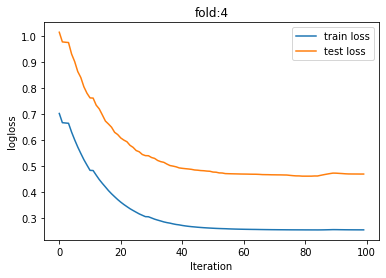

RMSE: [0.32204968320457217, 0.09499862446364173, 0.13840604066670592, 0.01912758695869076, 0.32677316519346095]
RMSE: 0.1802710200974143


In [6]:
start_opt = time.time()

y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 回帰を指定
          'metric': 'rmse',             # 回帰の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result_opt = []

for fold, (train_index, test_index) in enumerate(gkf.split(X_train_ce, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    lgb_train = opt_lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = opt_lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = opt_lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_opt.append(rmse)

print("RMSE:", cv_result_opt)
print("RMSE:", np.mean(cv_result_opt))

elasp_time_opt = round((time.time() - start_opt), 1)

## ベイズ最適化

In [7]:
start_bayes = time.time()

In [8]:
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
    params = {
        'application':'regression',
        'num_iterations':4000, 
        'learning_rate':0.05, 
        'early_stopping_round':100, 
        'metric':'rmse'
        }

    params["num_leaves"] = round(num_leaves)
    params['feature_fraction'] = max(min(feature_fraction, 1), 0)
    params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
    params['max_depth'] = round(max_depth)
    params['lambda_l1'] = max(lambda_l1, 0)
    params['lambda_l2'] = max(lambda_l2, 0)
    params['min_split_gain'] = min_split_gain
    params['min_child_weight'] = min_child_weight

    cv_result = lgb.cv(
        params, 
        train_data,
        nfold=n_folds, 
        seed=random_seed, 
        stratified=False, 
        verbose_eval =200, 
        metrics=['rmse']
        )
    
    return max(cv_result['rmse-mean'])

In [9]:
lgbBO = BayesianOptimization(
                        lgb_eval, 
                        {
                            'num_leaves': (24, 45),
                            'feature_fraction': (0.1, 0.9),
                            'bagging_fraction': (0.8, 1),
                            'max_depth': (5, 8.99),
                            'lambda_l1': (0, 5),
                            'lambda_l2': (0, 3),
                            'min_split_gain': (0.001, 0.1),
                            'min_child_weight': (5, 50)
                            }, 
                        random_state=SEED
)

In [10]:
def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=5, random_seed=6, n_estimators=10000, learning_rate=0.05, output_process=False):
    
    # prepare data
    train_data = lgb.Dataset(
                            data=X_train_ce,  ### 適宜要修正
                            label=y_train,   ### 適宜要修正
                            free_raw_data=False
                            )

    # parameters
    def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        
        params = {
            'application':'regression',
            'num_iterations': n_estimators, 
            'learning_rate':learning_rate, 
            'early_stopping_round':100, 
            'metric':'rmse'
            }

        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight

        cv_result = lgb.cv(
            params, train_data, 
            nfold=n_folds, 
            seed=random_seed, 
            stratified=False, 
            verbose_eval =200, 
            metrics=['rmse']
            )
        
        return max(cv_result['rmse-mean'])

    lgbBO = BayesianOptimization(lgb_eval, 
                                            {'num_leaves': (24, 45),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 8.99),
                                            'lambda_l1': (0, 5),
                                            'lambda_l2': (0, 3),
                                            'min_split_gain': (0.001, 0.1),
                                            'min_child_weight': (5, 50)}, random_state=0)
    # optimize
    lgbBO.maximize(init_points=init_round, n_iter=opt_round)
    
    # output optimization process
    if output_process==True: lgbBO.points_to_csv("bayes_opt_result.csv")
    
    # return best parameters
    return lgbBO.res[0]["params"]

In [11]:
opt_params = bayes_parameter_opt_lgb(
                                    X_train_ce, 
                                    y_train, 
                                    init_round=5, 
                                    opt_round=10, 
                                    n_folds=3, 
                                    random_seed=SEED, 
                                    n_estimators=100, 
                                    learning_rate=0.05
                                    )

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001058 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001085 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  1        |  0.7795   |  0.9098   |  0.6722   |  3.014    |  1.635    |  6.69     |  34.07    |  0.04432  |  42.73    |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, t

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001051 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Info] Start training from score 0.373233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  10       |  0.8126   |  1.0      |  0.1      |  0.0      |  3.0      |  5.0      |  42.6     |  0.001    |  45.0     |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001525 seconds.
You can set `force_co

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001014 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Info] Start training from score 0.373233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
|  12       |  0.8127   |  1.0      |  0.1      |  5.0      |  0.0      |  5.0      |  5.0      |  0.001    |  24.0     |
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features: 20
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021320 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 9060, number of used features:

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [12]:
print(opt_params)

{'bagging_fraction': 0.909762700785465, 'feature_fraction': 0.6721514930979355, 'lambda_l1': 3.0138168803582195, 'lambda_l2': 1.6346495489906907, 'max_depth': 6.690382649362229, 'min_child_weight': 34.065235087999525, 'min_split_gain': 0.04432113391500656, 'num_leaves': 42.727233016423675}


## ベストパラメータで学習・推論

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2292
[LightGBM] [Info] Number of data points in the train set: 10909, number of used features: 20
[LightGBM] [Info] Start training from score 0.356349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

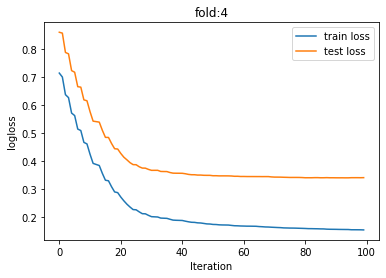

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2286
[LightGBM] [Info] Number of data points in the train set: 10933, number of used features: 20
[LightGBM] [Info] Start training from score 0.345808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

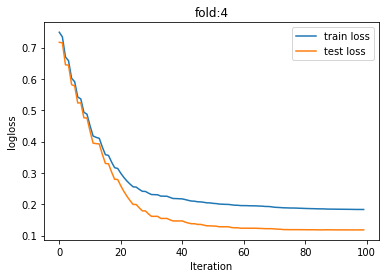

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2279
[LightGBM] [Info] Number of data points in the train set: 10965, number of used features: 19
[LightGBM] [Info] Start training from score 0.383112
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

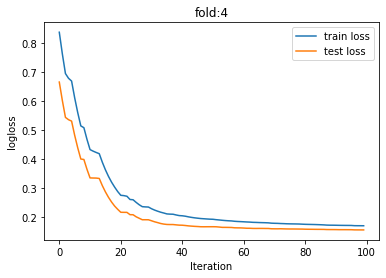

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 10733, number of used features: 20
[LightGBM] [Info] Start training from score 0.394992
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

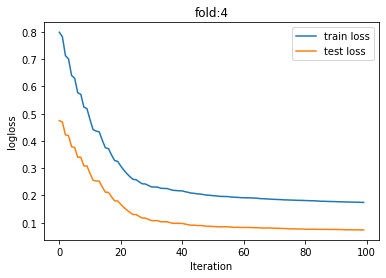

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2283
[LightGBM] [Info] Number of data points in the train set: 10820, number of used features: 20
[LightGBM] [Info] Start training from score 0.352462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

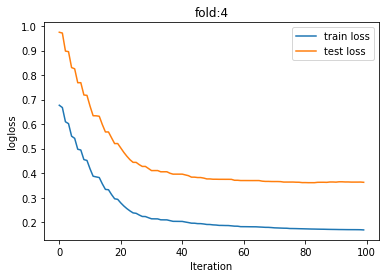

RMSE: [0.34132815070924105, 0.1180083899107749, 0.15441363020304533, 0.07356416653065098, 0.36271598327726196]
RMSE: 0.21000606412619485


In [13]:
y_train = y_train.reset_index(drop=True)

gkf = GroupKFold(n_splits=5)

groups = X_train_ce["Genre"]

lgb_results = {}                                    # 学習の履歴を入れる入物

opt_params["application"] = "regression" # 回帰を追加
opt_params["metrics"] = "rmse" # 評価指標を追加
opt_params["num_leaves"] = int(round(opt_params["num_leaves"])) # 整数に変換
opt_params["max_depth"] = int(round(opt_params["max_depth"])) # 整数に変換

cv_result_bayes = []

for train_index, test_index in gkf.split(X_train_ce, y_train, groups):
    X_train_gkf, X_test_gkf = X_train_ce.iloc[train_index], X_train_ce.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # データセットを登録
    lgb_train = lgb.Dataset(X_train_gkf, y_train_gkf)
    lgb_test = lgb.Dataset(X_test_gkf, y_test_gkf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params=opt_params,           # ベストパラメータをセット
                    train_set=lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                           # ログを最後の1つだけ表示
                    )
    
    # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_bayes.append(rmse)

print("RMSE:", cv_result_bayes)
print("RMSE:", np.mean(cv_result_bayes))

elasp_time_bayes = round((time.time() - start_bayes), 1)

In [14]:
print("Optuna RMSE:", round(np.mean(cv_result_opt), 3), "経過時間:", elasp_time_opt, "秒")
print("ベイズ最適化 RMSE:", round(np.mean(cv_result_bayes), 3), "経過時間:", elasp_time_bayes, "秒")

Optuna RMSE: 0.18 経過時間: 182.4 秒
ベイズ最適化 RMSE: 0.21 経過時間: 18.6 秒
